# Milestone 2: Project proposal and initial analyses

We chose the **[CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)**. This dataset contains 42,306 movie plot summaries extracted from Wikipedia + aligned metadata extracted from Freebase.

Using this dataset, we want to dive into the **drivers of an actor's success**, following several definitions.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import ast 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import statsmodels.api as sm

!pip install tqdm

import os
import gzip
from tqdm import tqdm
import xml.etree.ElementTree as ET

## 1. Exploration of the dataset

Many variables of the dataset are relevant to predict the success of an actor or an actress. Some are present in the characters dataset:
- Age at the beginning of their careers
- Age at the time of the movie
- Gender
- Ethnicity
- Height

Some are present in the movie dataset, but would need to be aggregated by actor:
- Movie release date (relative to the first film?): maybe some actors released their average movie during the golden age of the film industry?
- Movie language: maybe some languages allow to touch more people?
- Country of the movie: the country with the most occurence?

Some have to be constructed for this analysis:
- Variety of film genres in which the actor has played
- Variety of roles portrayed with an analysis of personas

### Movies metadata

In [3]:
movies = pd.read_table('./Data/MovieSummaries/movie.metadata.tsv', header=None)
movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
display(movies)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


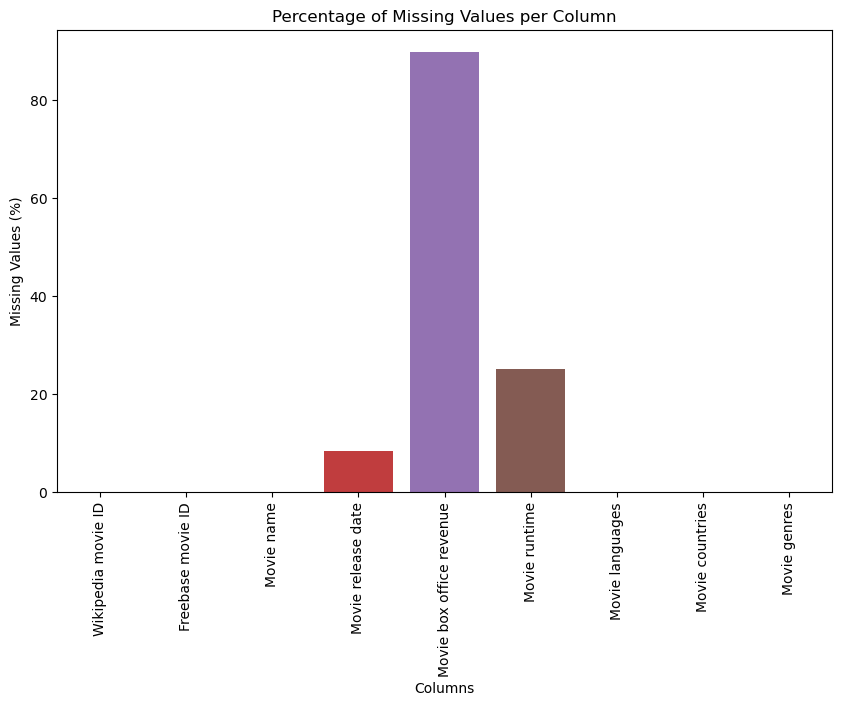

In [4]:
# Count missing values per column
missing_percent = (movies.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

# How will we deal with the large share of missing values for a key feature?

In [5]:
# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

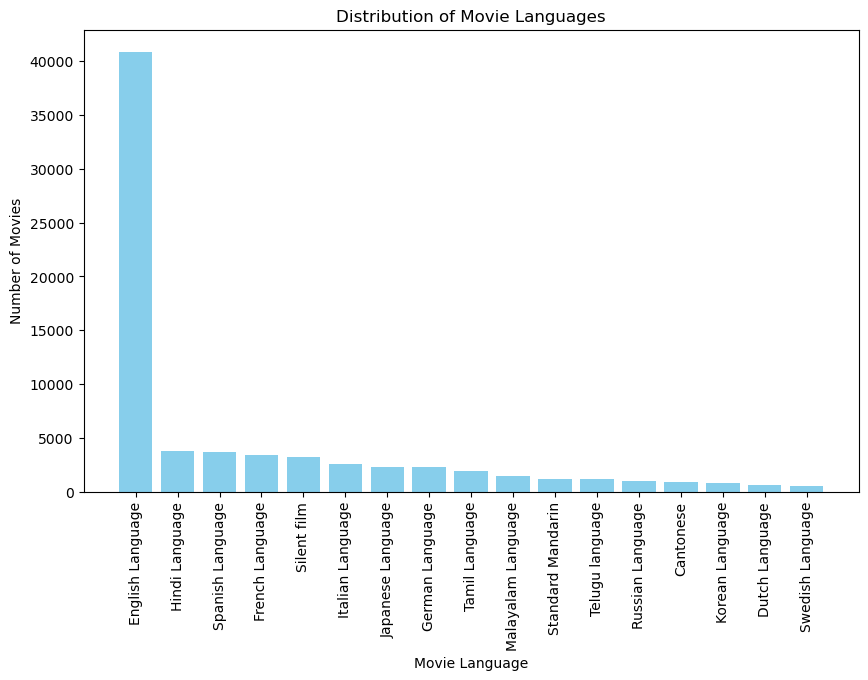

In [6]:
# Flatten the dictionaries and count language occurrences
language_counts = Counter(language for languages_dict in movies["Movie languages"] for language in languages_dict.values())

# Filter the language counts for readability
filtered_language_counts = {language: count for language, count in language_counts.items() if count > 500}
sorted_filtered_language_counts = dict(sorted(filtered_language_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
languages, counts = zip(*sorted_filtered_language_counts.items())
plt.bar(languages, counts, color='skyblue')
plt.xlabel('Movie Language')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Languages')
plt.xticks(rotation=90)  
plt.show()

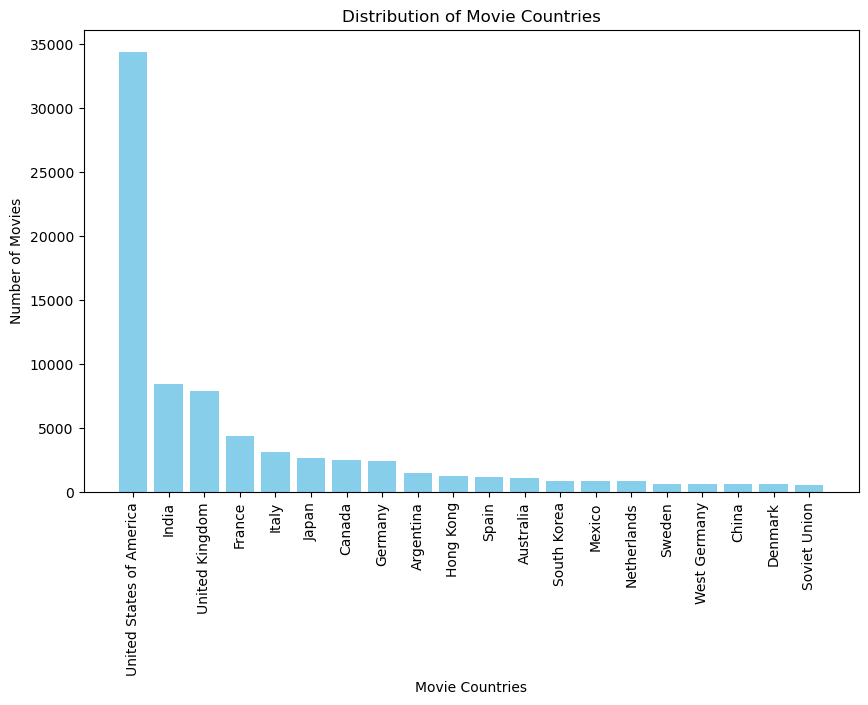

In [7]:
# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in movies["Movie countries"] for country in countries_dict.values())

# Filter the language counts for readability
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_filtered_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
countries, counts = zip(*sorted_filtered_countries_counts.items())
plt.bar(countries, counts, color='skyblue')
plt.xlabel('Movie Countries')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Countries')
plt.xticks(rotation=90)  
plt.show()

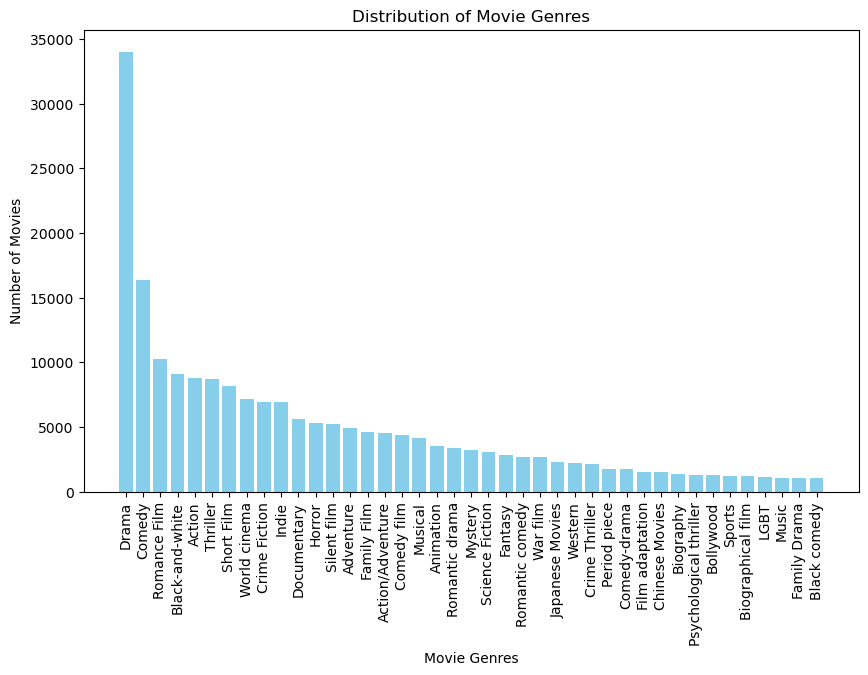

In [8]:
# Flatten the dictionaries and count countries occurrences
genres_counts = Counter(genre for genres_dict in movies["Movie genres"] for genre in genres_dict.values())

# Filter the language counts for readability
filtered_genres_counts = {genre: count for genre, count in genres_counts.items() if count > 1000}
sorted_filtered_genres_counts = dict(sorted(filtered_genres_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
genres, counts = zip(*sorted_filtered_genres_counts.items())
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Movie Genres')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=90)
plt.show()

### Characters metadata

In [9]:
characters = pd.read_table('./Data/MovieSummaries/character.metadata.tsv', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
display(characters)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


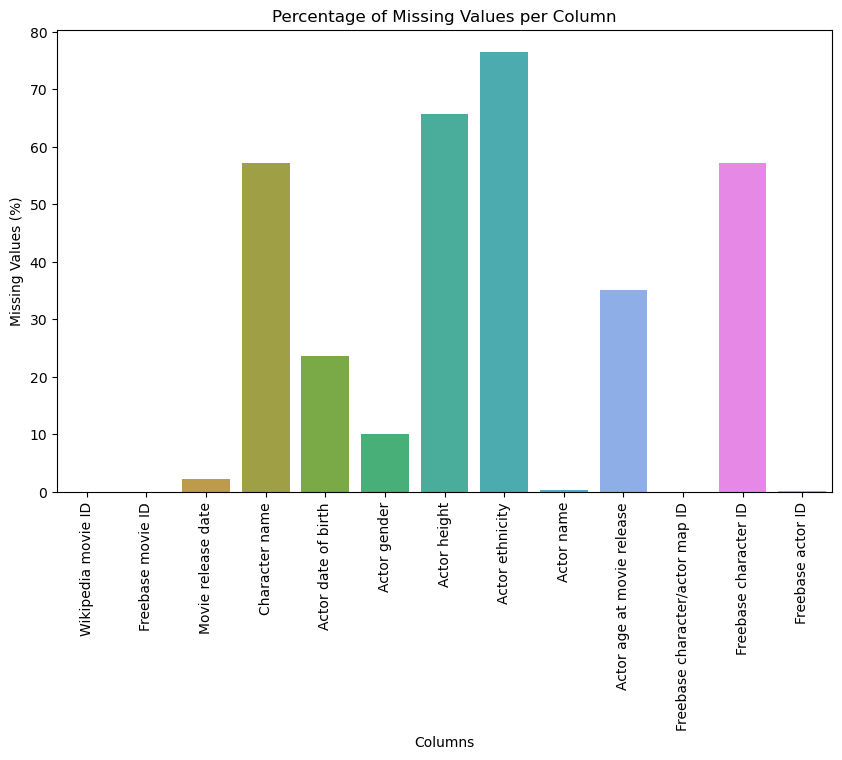

In [10]:
# Count missing values per column
missing_percent = (characters.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

## 2. Complementary datasets and initial analyses

The success can be characterized based on several factors, including:
- Longevity
- Number of movies played
- IMDB ratings
- The Oscars
- Google search results
- Film revenue
- Number of film spectators

Some of these indicators require additional datasets. We thus complement our analysis with data on awards, on ratings, and on popularity.

## 2.1 [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

### The dataset

In [11]:
oscars = pd.read_csv('./Data/oscar_awards.csv')
display(oscars)

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
11053,2017,SCIENTIFIC AND TECHNICAL AWARD (Scientific and...,True,"To LEONARD CHAPMAN for the overall concept, de..."
11054,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To JASON SMITH and JEFF WHITE for the original...
11055,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,"To JOE MANCEWICZ, MATT DERKSEN and HANS RIJPKE..."
11056,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To ALEX POWELL for his contribution to the des...


In [12]:
actors_oscars = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]
display(actors_oscars) 

# Until 1975, there was only one category for actors and one for actresses. 
# Nowadays, there are leading and supporting categories, so twice as many nominees each year.

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
10935,2017,ACTRESS IN A SUPPORTING ROLE,False,Mary J. Blige
10936,2017,ACTRESS IN A SUPPORTING ROLE,True,Allison Janney
10937,2017,ACTRESS IN A SUPPORTING ROLE,False,Lesley Manville
10938,2017,ACTRESS IN A SUPPORTING ROLE,False,Laurie Metcalf


In [13]:
characters_oscars = characters.merge(actors_oscars, left_on='Actor name', right_on='entity', how='left')

characters_oscars['entity'].isna().sum() # 418049
characters_oscars.shape[0] # 489192

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))
# How many nominees don't appear in the dataset?

There are 14.31% of Oscar nominees or winners in the movies dataset.


### Limitations of the dataset

The Oscars take place in the US and are usually political. It is less likely for popular foreign actors to win an award outside the best international film category, even if some film industries are very big outside of Hollywood, such as Bollywood and Nollywood.

We haven't found an exhaustive dataset of awards. We might decide to extend the analysis to more award ceremonies but none is exempt from this national preference: The Australian Film Institute Awards, The BAFTA Film Awards (UK), the Césars Film Awards (France), the Golden Bears (Germany), the Golden Globes (US), the Golden Lions (Venice), the Palme d'Or awards (France), the Sundance Film Festival awards (independent movies), Filmfare (Hindi), etc.

We do not aim at doing an exhaustive analysis, but it is important here to understand that we have a Western bias and we might need to use other indicators to better understand success of actors outside of Hollywood.

In [14]:
# What are movie nationalities of actors that won an Oscar?

characters_oscars_movies = characters_oscars[characters_oscars['winner'] == True].merge(movies, on='Freebase movie ID', how='left') 

In [15]:
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

sorted_countries_counts
# A lot of countries are represented, but the US is still largely above the rest.

{'United States of America': 34408,
 'India': 8411,
 'United Kingdom': 7868,
 'France': 4395,
 'Italy': 3163,
 'Japan': 2647,
 'Canada': 2534,
 'Germany': 2393,
 'Argentina': 1468,
 'Hong Kong': 1240,
 'Spain': 1136,
 'Australia': 1114,
 'South Korea': 887,
 'Mexico': 870,
 'Netherlands': 840,
 'Sweden': 657,
 'West Germany': 647,
 'China': 645,
 'Denmark': 610,
 'Soviet Union': 564}

### Initial analyses

**Predicting oscars with character metadata**

In [16]:
## Prepare the features vector for training ##

# Choose the relevant features
actors_features = ['Movie release date', 'Actor gender', 'Actor age at movie release', 'Actor height', 'Actor ethnicity']

X = characters_oscars[actors_features].copy()

# Removing missing values, for now imputations don't make sense here. 
# But because of ethnicity and height we get rid of a lot of observations
X_ = X[~(X.isna().any(axis=1))].copy()
len(X_[X_.isna().any(axis=1)])

X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

# Compute the number of days away from the first movie
X_.loc[:, 'release date'] = pd.to_datetime(X_['Movie release date'], format='mixed') # convert release date into date format 
X_['release date'] = (X_['release date'] - X_['release date'].min()).dt.days # and then into int

gender_mapping = {'F': 1, 'M': 2}
X_['Actor gender'] = X_['Actor gender'].map(gender_mapping) # Use a mapping to convert the 'gender' column to float

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the categorical variable and transform it
X_['Encoded ethnicity'] = label_encoder.fit_transform(X_['Actor ethnicity'])

X_ = X_.drop('Movie release date', axis=1)
X_ = X_.drop('Actor ethnicity', axis=1)

In [17]:
display(X_)

,Actor gender,Actor age at movie release,Actor height,release date,Encoded ethnicity
1,1,27.0,1.780,33838,139
2,2,32.0,1.727,33838,351
5,1,52.0,1.727,33838,351
55,2,31.0,1.630,35429,135
56,2,34.0,1.870,35429,99
...,...,...,...,...,...
488400,2,21.0,1.790,15705,352
488404,1,30.0,1.746,32572,99
488416,1,21.0,1.720,33968,135
488417,2,55.0,1.740,33968,135


In [18]:
## Prepare the outcome vector for training ##

# We want integers as outcomes
outcome_mapping = {0: 'is nominated for an Oscar', 1: 'wins an Oscar', 2: 'gets nothing'}

characters_oscars.loc[characters_oscars['winner'].isna(), 'winner'] = 2 # missing values mean not winner nor nominated
y = characters_oscars['winner'].astype('int')

# We remove the same observations as for the features vector
y_ = y[~(X.isna().any(axis=1))]

In [19]:
display(y_)

1         2
2         2
5         2
55        2
56        2
         ..
488400    2
488404    2
488416    2
488417    2
488439    2
Name: winner, Length: 86640, dtype: int32

In [20]:
## Training ##

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      5341
           1       0.34      0.22      0.26      1519
           2       0.98      0.99      0.99     10468

    accuracy                           0.88     17328
   macro avg       0.70      0.69      0.69     17328
weighted avg       0.87      0.88      0.87     17328



In [21]:
## Prediction of oscars based on an input vector of features ##

predicted_label = model.predict([[1,43,30000, 180, 120]])[0] # we need a mapping of ethnicities to interpret it
outcome = outcome_mapping[predicted_label]

print('This actor/actress {}.'.format(outcome))

This actor/actress gets nothing.


D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Next step: Analyze feature importance and add more features.
We should make sure to keep only movies that took place before the Oscar, as predicting an Oscar with movie characteristics such as release date post-Oscar doesn't make sense. Moreover, we can associate the Oscar with a specific movie, as it is not the entire career being awarded. 

## 2.2 Cumulated revenues of movies

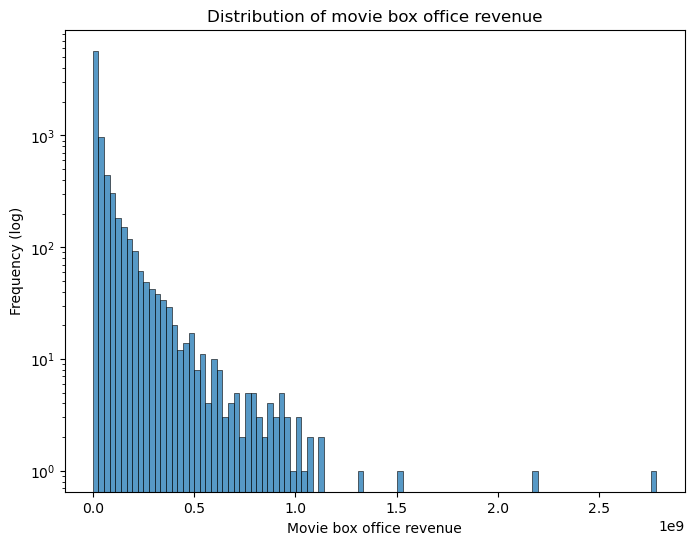

In [22]:
movies_revenues = movies['Movie box office revenue'].dropna().copy()

# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies_revenues, kde=False, bins=100)
plt.xlabel('Movie box office revenue')
plt.ylabel('Frequency (log)')
plt.title('Distribution of movie box office revenue')
plt.yscale("log")
plt.show()

### Limitations

Someone can play an unimportant role in many high revenues movies, it doesn't mean they are getting a lot of income from their movie. However, combined with other indicators, it can give us an idea of the success of someone. Note that we do not establish a causal relationship between the presence of an actor and the money the movie generated.

### Initial analyses

In [23]:
actors_movies = characters.merge(movies, on='Freebase movie ID', how='left') 

# Compute the number of days away from the first movie
actors_movies.loc[:, 'release date'] = pd.to_datetime(actors_movies['Movie release date_x'], format='mixed', errors = 'coerce') # convert release date into date format 
actors_movies['release date'] = (actors_movies['release date'] - actors_movies['release date'].min()).dt.days # and then into int

In [24]:
actors_revenues = actors_movies.groupby('Actor name')

# Custom aggregation function to get lists of unique values
unique_list = lambda x: len(list(set(val for sublist in x for val in sublist)))

# Aggregating the desired statistics
actor_statistics = actors_revenues.agg({
    'Movie box office revenue': 'sum',
    'Movie name': 'nunique',
    'Movie countries': unique_list,
    'Movie genres': unique_list,
    'Movie languages': unique_list,
    'Actor age at movie release': 'mean',
    'release date': 'mean'
}).reset_index()

# Renaming the columns for clarity
actor_statistics.columns = ['actor_name', 'total_revenues', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages', 'mean_age', 'mean_release'] 
                            
# Displaying the resulting DataFrame
display(actor_statistics) # problem with zero revenues to solve

,actor_name,total_revenues,unique_movies,unique_countries,unique_genres,unique_languages,mean_age,mean_release
0,Cesarine Prinz\t,0.0,2,1,2,0,NaN,13406.50
1,Daniel Newman,0.0,1,3,2,1,22.000000,40485.00
2,'Big Bill' Giddinger,0.0,1,1,5,1,NaN,8544.00
3,'Big' Lee,0.0,1,1,3,1,NaN,31251.00
4,'Chicken' Holleman,0.0,1,1,7,1,NaN,30845.00
...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,0.0,1,1,4,1,22.000000,42423.00
134074,雪乃五月,0.0,2,1,6,1,30.500000,41455.50
134075,高山久子,0.0,3,1,12,1,35.333333,40006.00
134076,高橋美紀,0.0,1,1,2,1,24.000000,35794.00


In [25]:
actors_movies = actors_movies.merge(actor_statistics, left_on='Actor name', right_on='actor_name')

In [26]:
## Naive linear regression ##

df = actors_movies.copy()

gender_mapping = {'F': 1, 'M': 2}
df['Actor gender'] = df['Actor gender'].map(gender_mapping)

# Adding a constant for the intercept term in the regression
df = sm.add_constant(df)

df = df[['const', 'mean_release', 'Actor gender', 'mean_age', 'Actor height', 'total_revenues', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages']]
print(df.shape)
df = df.dropna() # have to find an alternative, we lose over 70% of the data
print(df.shape)

# Defining the independent variables
independent_vars = ['const', 'mean_release', 'Actor gender', 'mean_age', 'Actor height', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages']

(449441, 10)
(147101, 10)


In [27]:
# Creating the model
model = sm.OLS(df['total_revenues'], df[independent_vars])

# Fitting the model
results = model.fit()

# Displaying the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         total_revenues   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.474e+04
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:53:33   Log-Likelihood:            -3.2697e+06
No. Observations:              147101   AIC:                         6.539e+06
Df Residuals:                  147092   BIC:                         6.540e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.479e+09   2.24e+07  

Every coefficient is statistically significant after performing a t-test.

We have to be careful with the timeframe: we predict cumulative revenues over the career, so we should use predictors that make sense over the course of a career as well. It does not make sense to use the age of an actor at the release of one specific movie to predict the revenues over all movies.

## 2.3 Longevity analysis

In order to do a 'longevity' analysis, we will focus on three main axis :  frequency of apparences per year, career span of each actor and finally total number of movies. At the end, we will try to find correlations between these 3 axis. 

### Frequency of appearances

In [28]:
column_characters = ["film_id", "movie_id", "release_date", "character", "born_date", "gender", "height", "ethnicity", "actor_name", "actor_age_at_movie_release", "actor_map_ID","character_ID","actor_ID"]
character_df = pd.read_csv('./Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names = column_characters)

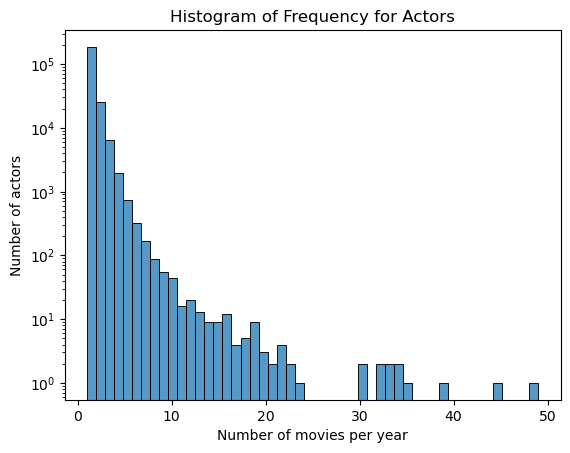

In [29]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

frequency_df = character_df.groupby(['actor_name', character_df['release_date'].dt.year]).size().reset_index(name='movie_count')
sns.histplot(frequency_df['movie_count'], bins = 50, log = True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies per year")
plt.title('Histogram of Frequency for Actors')
plt.show()

We can find several outliers that appears a lot. Let's focus on who they are : 

In [30]:
frequency_max = frequency_df.sort_values(by='movie_count', ascending=False)
top5_frequency = frequency_max.head(5)
print(top5_frequency)

             actor_name  release_date  movie_count
180202  Roscoe Arbuckle        1914.0           49
156501     Oliver Hardy        1916.0           45
76332      Harold Lloyd        1919.0           39
180201  Roscoe Arbuckle        1913.0           35
32608   Charlie Chaplin        1914.0           34


In fact, these actors mainly acted (during these years 1910s) in short movies so it might be biased during this period. One solution would be to consider them by period, which we will try to model later on. Another one could be to focus on the mean frequency over all the years : 

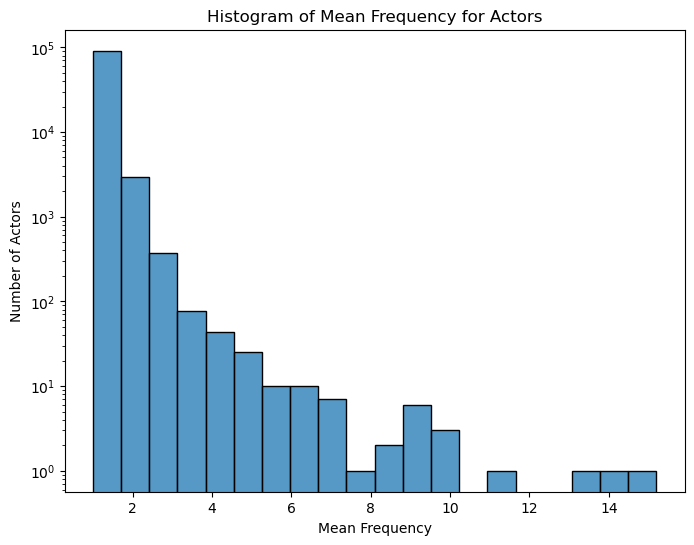

In [31]:
mean_frequency = frequency_df.groupby('actor_name')['movie_count'].mean().reset_index(name='mean_frequency')

plt.figure(figsize=(8, 6))
sns.histplot(mean_frequency['mean_frequency'], bins=20,log = True, kde=False)
plt.xlabel('Mean Frequency')
plt.ylabel('Number of Actors')
plt.title('Histogram of Mean Frequency for Actors')
plt.show()

In [32]:
top5_actors_mf = mean_frequency.nlargest(5, 'mean_frequency')
print(top5_actors_mf)

             actor_name  mean_frequency
14425  Charlotte Burton            15.2
54785     Louise Lester            14.0
37143        Jack Davis            13.5
90908       Vivian Rich            11.2
13107    Caroline Cooke            10.0


When we search for all these actors, we can see that they are all from the beginning of the movie industry (1910s, early 1920s) when the movies were quite short and silent, so the artistic approach was way more simplified as today. In fact, Roscoe Arbuckle worked as the same time as an actor, a screenwriter and a producer. 

By highlighting that, we could assess that taking into account the period at which the movies were produced is critical. 

So, we tried to filter by period( NB : before 1908, a lot of Nan values occurs so we just filtered) :

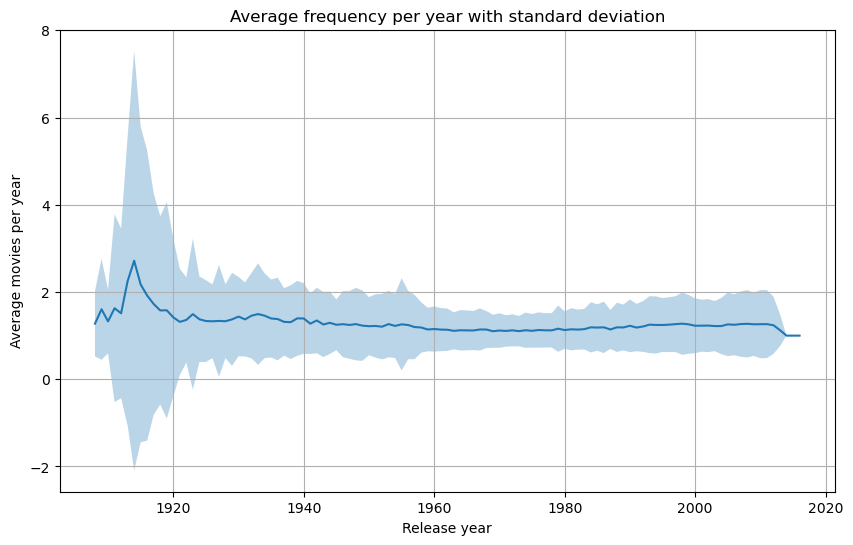

In [33]:
average_movie_count_per_year = frequency_df.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_per_year.columns = ['release_date', 'average_movies', 'std_dev']

average_movie_count_per_year = average_movie_count_per_year[average_movie_count_per_year['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_per_year, x='release_date', y='average_movies')
plt.fill_between(average_movie_count_per_year['release_date'], 
                 average_movie_count_per_year['average_movies'] - average_movie_count_per_year['std_dev'],
                 average_movie_count_per_year['average_movies'] + average_movie_count_per_year['std_dev'],
                 alpha=0.3)
plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average frequency per year with standard deviation')
plt.grid(True)
plt.show()

Overall, the frequency seems to be constant over the years so it might be a critical features in our final. 

### Career span 

The second axis might be to study the career span of actors and find insights about that :

Mean career span for male actors: 13.08 years (+/-  11.21) 
Mean career span for female actors: 11.38 years (+/- 10.74) 


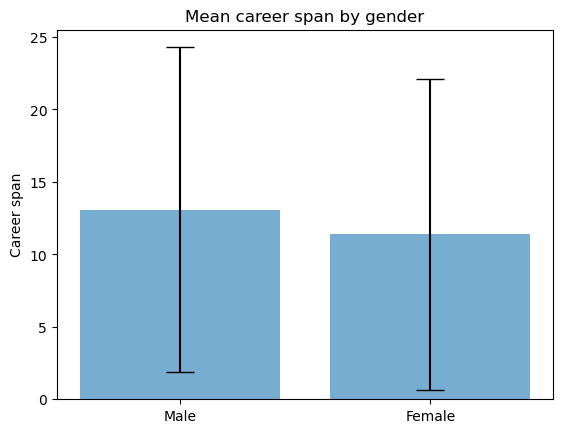

In [34]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

actor_span = character_df.groupby('actor_name')['release_date'].agg(['min', 'max']).reset_index()
actor_span['career_span'] = (actor_span['max'] - actor_span['min']).dt.days / 365

# Avoid anomalies due to missing values (NaT)
span_thresh = 50 
actor_span = actor_span[(actor_span['career_span'] != 0) & (actor_span['career_span'] < span_thresh)]
actor_career_span = actor_span.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
actor_career_span = actor_career_span.drop_duplicates(subset=['actor_name', 'career_span', 'gender'])

male_actors = actor_career_span[actor_career_span['gender'] == 'M']
female_actors = actor_career_span[actor_career_span['gender'] == 'F']

# Calculate mean career span for male and female actors and std and plot with confidence intervals
mean_career_span_male = male_actors['career_span'].mean()
std_career_span_male = male_actors['career_span'].std()
mean_career_span_female = female_actors['career_span'].mean()
std_career_span_female = female_actors['career_span'].std()

print(f"Mean career span for male actors: {mean_career_span_male:.2f} years (+/-  {std_career_span_male:.2f}) ")
print(f"Mean career span for female actors: {mean_career_span_female:.2f} years (+/- {std_career_span_female:.2f}) ")

labels = ['Male', 'Female']
x_pos = range(len(labels))
plt.bar(x_pos, [mean_career_span_male, mean_career_span_female], yerr=[std_career_span_male, std_career_span_female], align='center', alpha=0.6, ecolor='black', capsize=10)
plt.xticks(x_pos, labels)
plt.ylabel('Career span')
plt.title('Mean career span by gender')

plt.show()

One could infer that there is no significant difference between male and female (a first glimpse at this feature might reveal interesting stuff to consider later). Let's run a t-test to verify it : 

In [35]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(male_actors['career_span'], female_actors['career_span'])

print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.4f}")

t-statistic: 13.15, p-value: 0.0000


We can assess that there is strong evidence about the difference between male and female actors. 

### Total number of movies 

The final axis of the longevity analysis will be the most explicit one : total number of movies throughout career. 

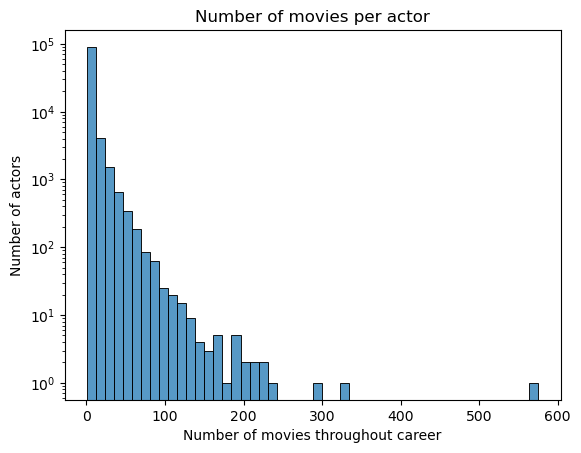

In [36]:
actor_nb_movie = character_df.groupby(['actor_name', 'gender', 'movie_id']).size().reset_index(name='appearance_count')
actor_nb_movie = actor_nb_movie.groupby(['actor_name', 'gender']).size().reset_index(name='total_movie_count')

sns.histplot(actor_nb_movie, x='total_movie_count', bins=50, log=True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor")
plt.show()

Here again we can find a particular outlier : more than 500 movies ! Let's find out where that comes from : 

In [37]:
sorted_actors = actor_nb_movie.sort_values(by='total_movie_count', ascending=False) 
top_5_actors_corrected = sorted_actors.head(5)
print(top_5_actors_corrected)

               actor_name gender  total_movie_count
62041           Mel Blanc      M                575
64910  Mithun Chakraborty      M                328
69057        Oliver Hardy      M                299
65110            Mohanlal      M                234
57406           Mammootty      M                225


The top 5 is mainly composed of mens, let's try to compare with women. In fact, we may have to consider productions locally and by period too, because the leaderboard is exclusively from America in the early ages of cinema and from India nowadays for example.

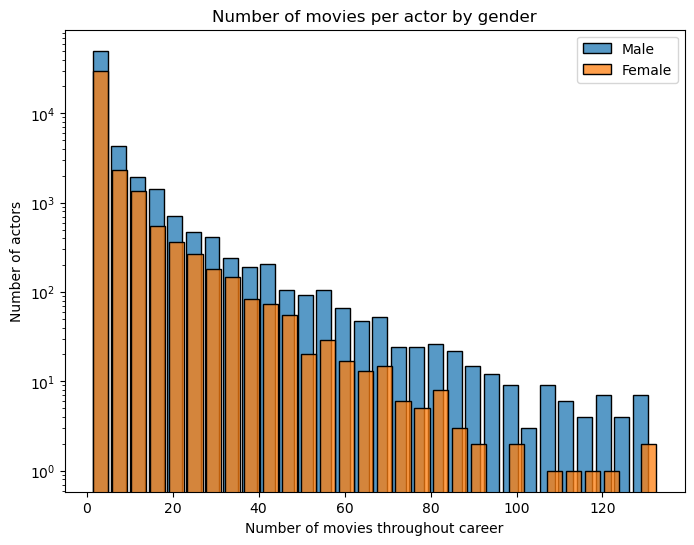

In [38]:
male_data = actor_nb_movie[actor_nb_movie['gender'] == 'M']
female_data = actor_nb_movie[actor_nb_movie['gender'] == 'F']

# The max number of movies for women are 133 so we filter values above to compare
male_filtered = male_data[male_data['total_movie_count'] <= 133]
female_filtered = female_data[female_data['total_movie_count'] <= 133]

# Plotting separate histograms for men and women with filtered data
plt.figure(figsize=(8, 6))
sns.histplot(male_filtered['total_movie_count'], bins=30, label='Male', log=True, multiple="dodge", shrink=.8)
sns.histplot(female_filtered['total_movie_count'], bins=30, label='Female', log=True, multiple="dodge", shrink=.8)

plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor by gender")
plt.legend()
plt.show()

Overall, it is clear that women tend to do fewer movies than men. We will delve intop this aspect for P3 to find more relevant analysis.

### Combination of all the factors

First we can try a first regression between the two main longevity axis : 

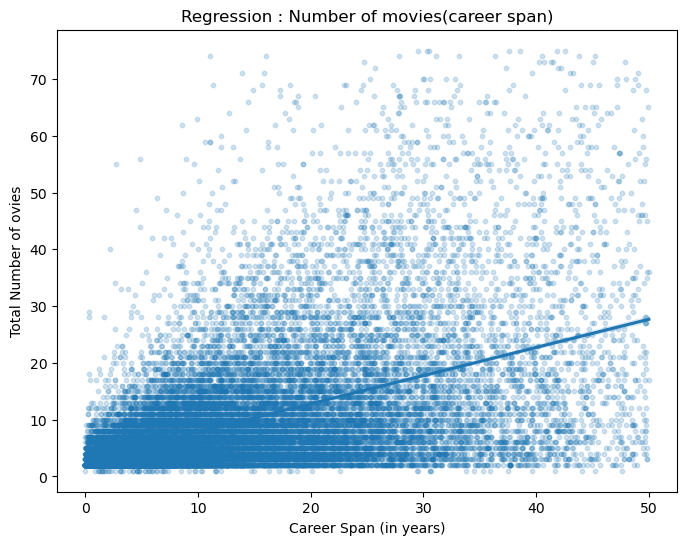

In [39]:
merged_data = pd.merge(actor_span, actor_nb_movie, on='actor_name', how='inner')

# Remove outliers for better visualization
thresh = 75
merged_data = merged_data[merged_data['total_movie_count'] <=  thresh]

# Perform a regression
plt.figure(figsize=(8, 6))
sns.regplot(x='career_span', y='total_movie_count', data=merged_data, scatter_kws={"s": 10, "alpha": 0.2})
plt.xlabel("Career Span (in years)")
plt.ylabel("Total Number of ovies")
plt.title("Regression : Number of movies(career span)")
plt.show()

An obvious observation could be that number of movies increases with career span. But it can be different between regions, gender and history. 

To generalize our study, we can do the pairplot of the three features : 

              actor_name  movies_per_actor  career_span  mean_frequency
0       Cesarine Prinz\t               2.0     4.238356             1.0
2   'Big Bill' Giddinger               1.0     8.438356             1.0
25  A. Edward Sutherland               1.0    14.378082             2.0
36           A. Kanayeva               1.0    11.150685             1.0
45            A. Smirnov               1.0     6.728767             1.0


D:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


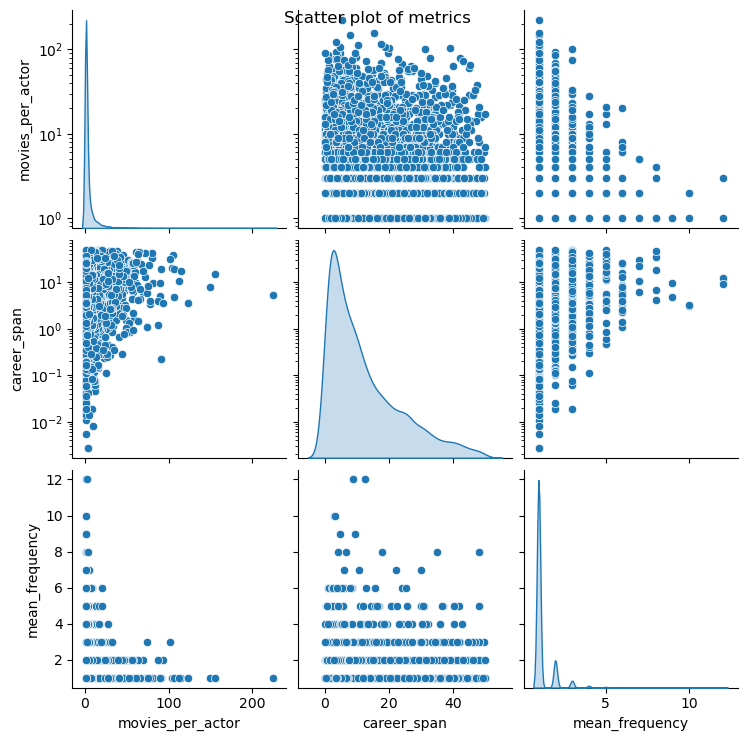

In [40]:
actor_metrics = pd.DataFrame({
    'actor_name': actor_nb_movie['actor_name'],
    'movies_per_actor': actor_nb_movie['total_movie_count'],
    'career_span': actor_career_span['career_span'],  
    'mean_frequency': frequency_df['movie_count'],
})

actor_metrics = actor_metrics.dropna()  

print(actor_metrics.head())
g = sns.pairplot(actor_metrics, diag_kind='kde')

for i in range(g.axes.shape[0] - 1):
    for j in range(g.axes.shape[1] - 1):
        ax = g.axes[i, j]
        if i == j:
            ax.set_yscale('log')

plt.suptitle('Scatter plot of metrics')
plt.show()

A further analysis will allow us to find insights between thesse 3 features, and one more time : adapt our approach between gender, historical and geographical informations. 

## 2.4 [IMDb movies' ratings](https://developer.imdb.com/non-commercial-datasets/)

We want to observe how successful an actor is through different scopes and the easiest way to judge an actor and a movie is with audience's ratings. Therefore we are using the IMDb datasets to analyze the performance of actors seen from the general public's perspective.

### Datasets manipulation

We will only be working with the following files :
- ratings.tsv which contains ratings for movies
- titles_imdb.tsv which contains the title of the movies

In [41]:
ratings = pd.read_csv('Data/ratings.tsv', sep='\t')
imdb_movies = pd.read_csv('Data/titles_imdb.tsv', sep='\t')

C:\Users\pasca\AppData\Local\Temp\ipykernel_8384\3750461216.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_movies = pd.read_csv('Data/titles_imdb.tsv', sep='\t')


In [42]:
display(ratings)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688
...,...,...,...
1366964,tt9916730,7.6,11
1366965,tt9916766,7.0,22
1366966,tt9916778,7.2,36
1366967,tt9916840,8.8,6


In [43]:
display(imdb_movies)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10298939,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10298940,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10298941,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10298942,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [44]:
movie_ratings = pd.merge(imdb_movies, ratings)
display(movie_ratings)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,2005
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",5.8,269
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1908
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",5.5,178
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2688
...,...,...,...,...,...,...,...,...,...,...,...
1366962,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama,7.6,11
1366963,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,\N,43,"Family,Game-Show,Reality-TV",7.0,22
1366964,tt9916778,tvEpisode,Escape,Escape,0,2019,\N,\N,"Crime,Drama,Mystery",7.2,36
1366965,tt9916840,tvEpisode,Horrid Henry's Comic Caper,Horrid Henry's Comic Caper,0,2014,\N,11,"Adventure,Animation,Comedy",8.8,6


We now need to merge our new dataset with the movies dataset from the CMU Corpus.

In [45]:
movie_ratings_2 = pd.merge(movies, movie_ratings, left_on=["Movie name"], right_on=["primaryTitle"])
movie_ratings_2.head(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",tt0228333,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,56894
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",tt0594845,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.6,20
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",tt0094806,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.6,40
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},tt0083949,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,5.9,623
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",tt0002894,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",tt0139667,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime",5.6,33
6,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",tt27788655,movie,The Gangsters,The Gangsters,0,2019,\N,\N,Action,6.2,6
7,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/05p553': 'Comedy film'},tt0002894,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16
8,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/05p553': 'Comedy film'},tt0139667,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime",5.6,33
9,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/05p553': 'Comedy film'},tt27788655,movie,The Gangsters,The Gangsters,0,2019,\N,\N,Action,6.2,6


As displayed above, there are multiple movies that have the same name. So in order to avoid the confusion between movies' titles, we have to add another parameter to merge the two dataframes on: the most logical one would be the year.

In [46]:
movie_ratings["startYear"] = movie_ratings["startYear"].astype(str)

In [47]:
# Function to extract the year from the release date
def extract_year(date_string):
    try:
        date = pd.to_datetime(date_string)
        return date.year
    except (ValueError, TypeError):
        return date_string

In [48]:
movies['Year'] = movies['Movie release date'].apply(extract_year)
movies['Year'] = movies['Year'].astype(str)

In [49]:
display(movies)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2011
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",2011
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...",1992


In [50]:
movie_ratings_2 = pd.merge(movies, movie_ratings, left_on=["Movie name", "Year"], right_on=["primaryTitle", "startYear"])
display(movie_ratings_2)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,56894
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.6,20
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.6,40
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,5.9,623
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51101,15394941,/m/03m6zh4,Gopi Kishan,1994-12-02,NaN,NaN,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},"{'/m/07s9rl0': 'Drama', '/m/02kdv5l': 'Action'...",1994,...,movie,Gopi Kishan,Gopi Kishan,0,1994,\N,161,"Action,Comedy,Drama",5.8,964
51102,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,movie,The Ghost Train,The Ghost Train,0,1941,\N,85,"Comedy,Horror",6.2,1582
51103,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2011,...,tvMovie,Mermaids: The Body Found,Mermaids: The Body Found,0,2011,\N,82,Sci-Fi,4.6,1711
51104,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",2011,...,movie,Knuckle,Knuckle,0,2011,\N,97,"Biography,Documentary,Drama",6.8,3193


We notice that about 30,000 movies have been removed from the initial dataset.

Now let us merge with the actors dataframe and calculate the weighted average rating for each actor.

In [51]:
actors_ratings = pd.merge(movie_ratings_2, characters, on="Wikipedia movie ID")
display(actors_ratings)

,Wikipedia movie ID,Freebase movie ID_x,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year,...,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355412,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,NaN,1900-01-14,M,NaN,NaN,Wilfrid Lawson,41.0,/m/0gcgrfv,NaN,/m/025w40r
355413,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,NaN,1891-08-08,M,NaN,NaN,Morland Graham,NaN,/m/0gckksz,NaN,/m/0gc08qy
355414,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,NaN,1869,M,NaN,NaN,D.J. Williams,NaN,/m/0gdk36r,NaN,/m/0gcwx9k
355415,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}",1972,...,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5


In [52]:
actors_ratings["avgRating"] = actors_ratings["averageRating"] * actors_ratings["numVotes"]

In [53]:
weighted_avg_rat = actors_ratings.groupby('Actor name')['avgRating'].sum() / actors_ratings.groupby('Actor name')['numVotes'].sum()
nb_movies_per_act = actors_ratings.groupby('Actor name')['Movie name'].count()

In [54]:
df_nb_movies = pd.DataFrame({'Actor': weighted_avg_rat.index, 'Movies count': nb_movies_per_act.values})
df_ratings = pd.DataFrame({'Actor': weighted_avg_rat.index, 'Rating': weighted_avg_rat.values})
df_result = pd.merge(df_ratings, df_nb_movies)
df_result_sort = df_result.sort_values(by="Rating", ascending=False)
display(df_result_sort)

,Actor,Rating,Movies count
93926,Taira Court,10.0,1
34469,Gloria Laso,10.0,1
49377,Josefina González,10.0,1
81800,Ricardo Fernández,10.0,1
88614,Sergio Moliner,9.9,1
...,...,...,...
85757,Ryan Christiansen,1.1,1
48766,Jon Jon Briones,1.1,1
36936,Hayley Chase,1.1,1
57241,Lawson Harris,1.0,1


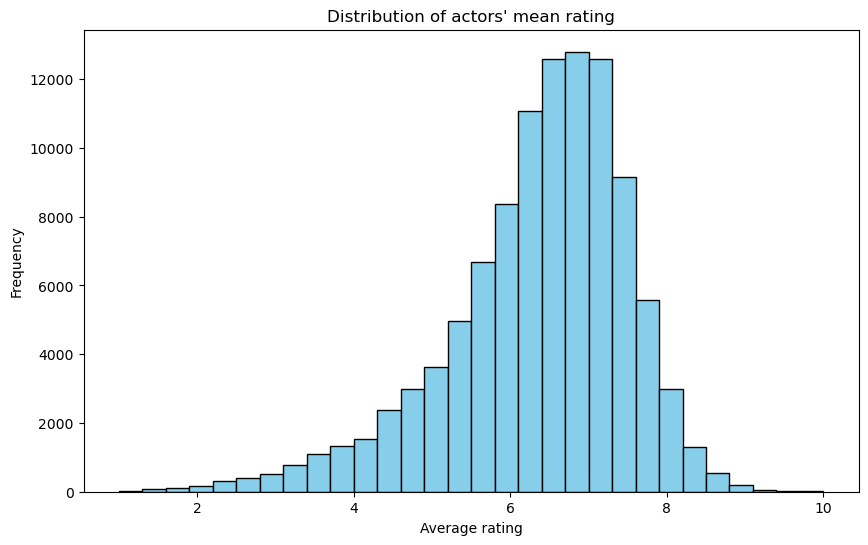

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(df_result['Rating'], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Average rating')
plt.ylabel('Frequency')
plt.title("Distribution of actors' mean rating")

plt.show()

In [56]:
df_result.describe()

,Rating,Movies count
count,104255.000000,104255.000000
mean,6.322880,3.400067
std,1.162767,7.310288
min,1.000000,1.000000
25%,5.704164,1.000000
50%,6.500000,1.000000
75%,7.100000,3.000000
max,10.000000,601.000000


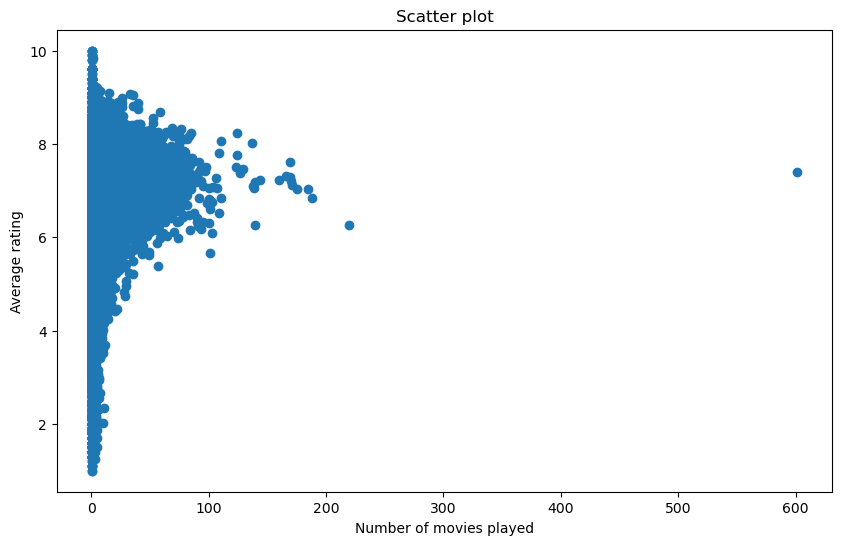

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(df_result['Movies count'], df_result['Rating'])
plt.xlabel('Number of movies played')
plt.ylabel('Average rating')
plt.title('Scatter plot')
plt.show()

In [58]:
# Removing the outlier for better visualization
df_visualize = df_result[df_result['Movies count'] < 600]

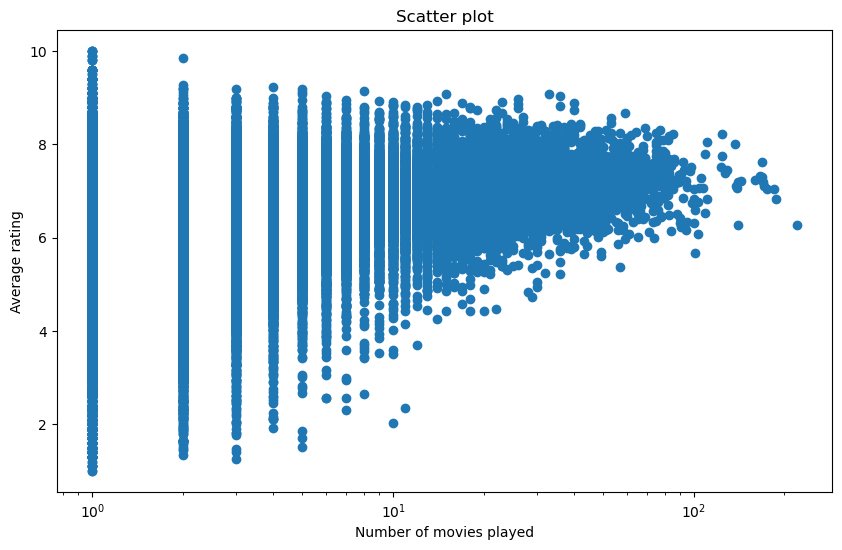

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(df_visualize['Movies count'], df_visualize['Rating'])
plt.xscale('log')
plt.xlabel('Number of movies played')
plt.ylabel('Average rating')
plt.title('Scatter plot')
plt.show()

Extreme values of ratings usually appear for actors who have played in very few movies. Actors who have played in more movies have their rating slightly skewed towards positive ratings. We will dive deeper into this analysis for the next and final milestone and also try to establish connections with the other factors.

In [110]:
# Aggregation function to get the length of list of unique values in dictionaries
def count_unique(series):
    if all(not my_dict for my_dict in series):
        return None
    else:
        return len(set(val for sublist in series for val in sublist))
    #return len(unique_countries) if unique_countries else None  # Return None for empty sets

# Aggregation function to get the most frequent value of a column
def most_frequent_occ(series): 
    if not series.empty and not series.isna().all():
        return series.mode().iloc[0]  
    else:
        return None
    
def most_frequent_in_dictionary(series):
    if all(not my_dict for my_dict in series):
        return None
       
    else:
        # Flatten the list of dictionaries
        flattened_values = [item for sublist in series for item in sublist.values()]

        # Create a pandas Series from the flattened values
        flattened_series = pd.Series(flattened_values)

        # Calculate the mode of the flattened Series
        mode_value = flattened_series.mode().iloc[0]
        return mode_value

In [61]:
actors_revenues = actors_movies.groupby('Actor name')

# Aggregating the desired statistics
actor_statistics = actors_revenues.agg({
    'Movie box office revenue': lambda x: x.fillna(0).sum(),
    'Actor gender': most_frequent_occ,
    'Actor age at movie release': 'mean',
    'Actor ethnicity': most_frequent_occ,
    'Actor height': most_frequent_occ,
    'Movie languages': most_frequent_in_dictionary,
    'Movie countries': most_frequent_in_dictionary,
    'Movie genres': most_frequent_in_dictionary,
    'Movie name': 'nunique'
}).reset_index()

In [62]:
actor_statistics

,Actor name,Movie box office revenue,Actor gender,Actor age at movie release,Actor ethnicity,Actor height,Movie languages,Movie countries,Movie genres,Movie name
0,Cesarine Prinz\t,0.0,F,NaN,None,NaN,None,Netherlands,Comedy,2
1,Daniel Newman,0.0,M,22.000000,None,NaN,English Language,Canada,Drama,1
2,'Big Bill' Giddinger,0.0,M,NaN,None,NaN,English Language,United States of America,History,1
3,'Big' Lee,0.0,M,NaN,None,NaN,English Language,United States of America,Crime Fiction,1
4,'Chicken' Holleman,0.0,None,NaN,None,NaN,English Language,United States of America,Crime Fiction,1
...,...,...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,0.0,M,22.000000,None,1.85,Japanese Language,Japan,Drama,1
134074,雪乃五月,0.0,F,30.500000,None,NaN,Japanese Language,Japan,Action,2
134075,高山久子,0.0,F,35.333333,None,NaN,Japanese Language,Japan,Animation,3
134076,高橋美紀,0.0,F,24.000000,None,NaN,Japanese Language,Japan,Animation,1


In [79]:
analysis_ratings = pd.merge(actor_statistics, df_result, left_on="Actor name", right_on="Actor")
analysis_ratings

,Actor name,Movie box office revenue,Actor gender,Actor age at movie release,Actor ethnicity,Actor height,Movie languages,Movie countries,Movie genres,Movie name,Actor,Rating,Movies count
0,Daniel Newman,0.0,M,22.000000,None,NaN,English Language,Canada,Drama,1,Daniel Newman,5.800000,1
1,'Big Bill' Giddinger,0.0,M,NaN,None,NaN,English Language,United States of America,History,1,'Big Bill' Giddinger,6.900000,1
2,'Big' Lee,0.0,M,NaN,None,NaN,English Language,United States of America,Crime Fiction,1,'Big' Lee,5.700000,1
3,'Chicken' Holleman,0.0,None,NaN,None,NaN,English Language,United States of America,Crime Fiction,1,'Chicken' Holleman,6.000000,1
4,'Evil' Ted Smith,0.0,None,NaN,None,NaN,English Language,Japan,Action,1,'Evil' Ted Smith,4.900000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104250,關淑怡,0.0,F,28.000000,None,NaN,Cantonese,Hong Kong,Chinese Movies,2,關淑怡,7.681850,2
104251,陳文媛,0.0,F,23.000000,None,NaN,Cantonese,Hong Kong,Chinese Movies,1,陳文媛,3.000000,1
104252,陳曉東,0.0,M,29.000000,None,1.80,Standard Mandarin,Hong Kong,Drama,2,陳曉東,6.041848,2
104253,雅-miyavi-,0.0,M,22.000000,None,1.85,Japanese Language,Japan,Drama,1,雅-miyavi-,6.700000,1


In [131]:
ratings_mf = analysis_ratings.groupby('gender')['rating'].mean()
ratings_mf_std = analysis_ratings.groupby('gender')['rating'].std()
ratings_mf

gender
F    6.348841
M    6.407009
Name: rating, dtype: float64

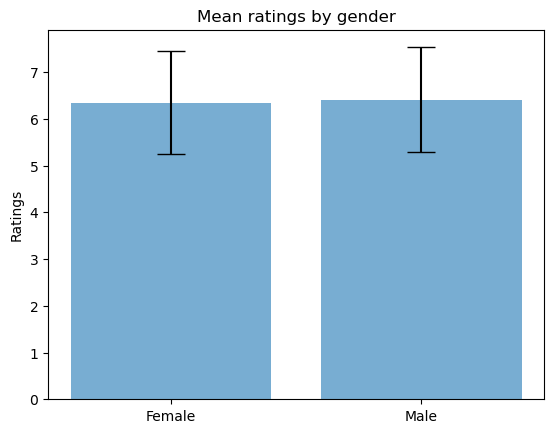

In [133]:
labels = ['Female', 'Male']
x_pos = range(len(labels))
plt.bar(x_pos, ratings_mf.values, yerr=ratings_mf_std.values, align='center', alpha=0.6, ecolor='black', capsize=10)
plt.xticks(x_pos, labels)
plt.ylabel('Ratings')
plt.title('Mean ratings by gender')

plt.show()

In [135]:
ratings_per_mgenre = analysis_ratings.groupby('most_freq_genre')['rating'].mean()
ratings_per_mgenre

most_freq_genre
Absurdism           6.341162
Acid western        6.346209
Action              5.845059
Action Comedy       7.268205
Action Thrillers    5.506624
                      ...   
War film            6.461735
Western             6.081624
World cinema        6.566449
Wuxia               4.500000
Zombie Film         6.500000
Name: rating, Length: 185, dtype: float64

In [122]:
ratings_per_country = analysis_ratings.groupby('most_freq_country')['rating'].mean()
ratings_per_country

most_freq_country
Afghanistan        7.297074
Albania            6.704914
Algeria            7.233324
Argentina          6.458395
Armenia            6.733333
                     ...   
Vietnam            6.543182
Weimar Republic    7.250000
West Germany       6.242733
Yugoslavia         7.346193
Zimbabwe           6.300000
Name: rating, Length: 116, dtype: float64

In [136]:
ratings_per_language = analysis_ratings.groupby('most_freq_language')['rating'].mean()
ratings_per_language

most_freq_language
Aboriginal Malay languages    6.399976
Afrikaans Language            7.040539
Albanian language             6.833003
Algonquin Language            6.700000
American English              6.077525
                                ...   
Vietnamese Language           7.242315
Welsh Language                7.100000
Wolof Language                6.860832
Yiddish Language              7.350000
Zulu Language                 7.500000
Name: rating, Length: 125, dtype: float64

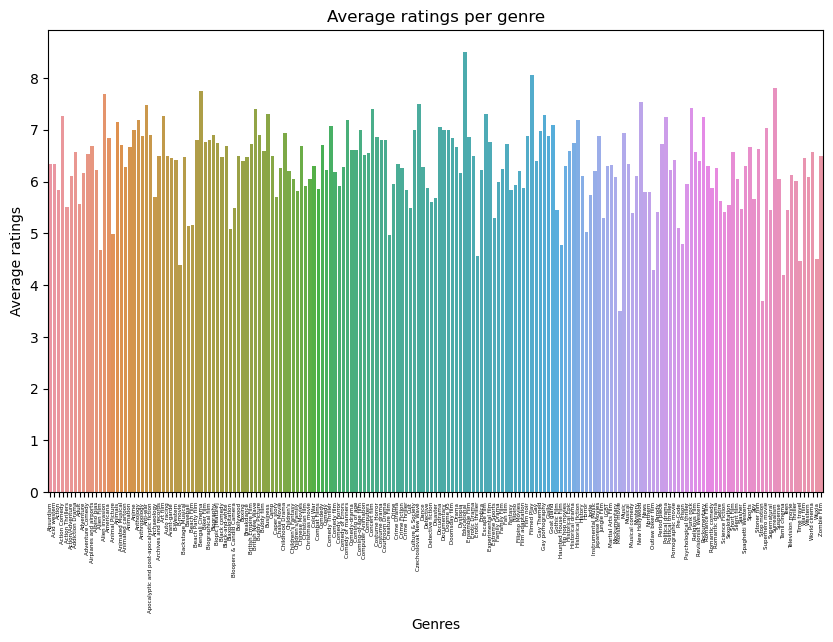

In [148]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings_per_mgenre.index, y=ratings_per_mgenre.values)
plt.xticks(size=4, rotation=90)  
plt.xlabel('Genres')
plt.ylabel('Average ratings')
plt.title('Average ratings per genre')
plt.show()

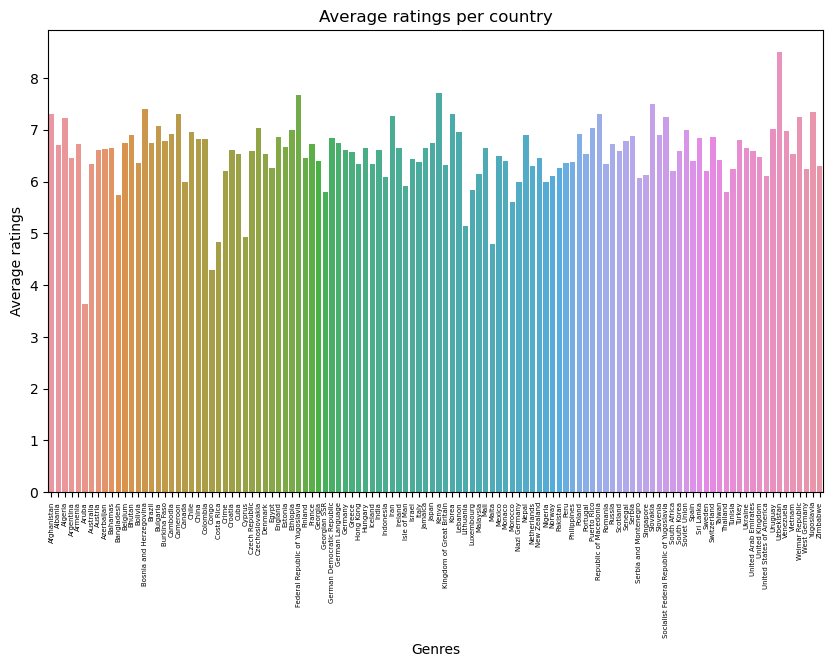

In [146]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings_per_country.index, y=ratings_per_country.values)
plt.xticks(size=5, rotation=90)  
plt.xlabel('Genres')
plt.ylabel('Average ratings')
plt.title('Average ratings per country')
plt.show()

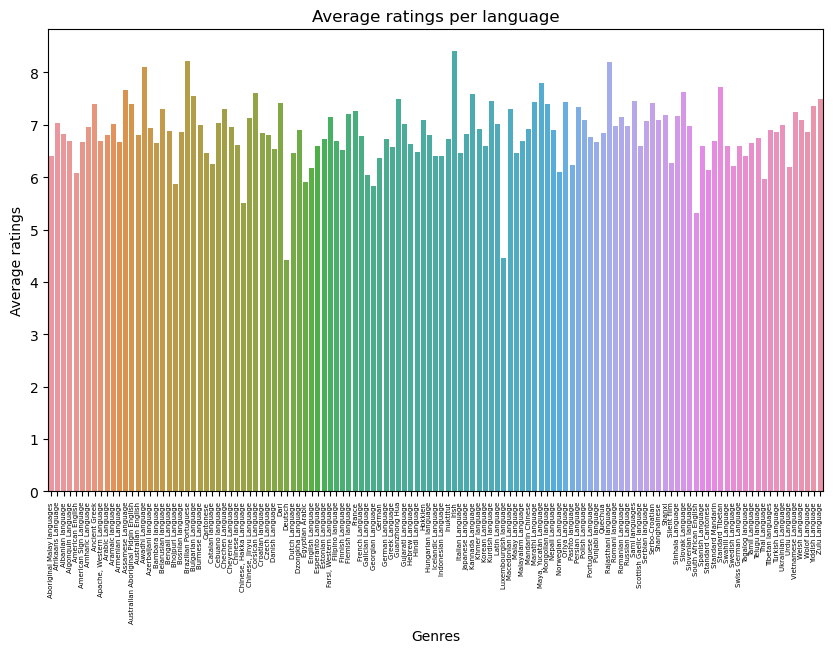

In [145]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings_per_language.index, y=ratings_per_language.values)
plt.xticks(size=5, rotation=90)  
plt.xlabel('Genres')
plt.ylabel('Average ratings')
plt.title('Average ratings per language')
plt.show()

In [81]:
# More statistics
age_begin_career = actors_revenues['Actor age at movie release'].min()
unique_countries = actors_revenues['Movie countries'].apply(count_unique) # doesnt work
unique_genres = actors_revenues['Movie genres'].apply(count_unique)
unique_languages = actors_revenues['Movie languages'].apply(count_unique)

# We need precise mapping because they have other columns in common with different values, resulting in NaN
analysis_ratings['age_begin_career'] = analysis_ratings['Actor name'].map(age_begin_career)
analysis_ratings['unique_countries'] = analysis_ratings['Actor name'].map(unique_countries)
analysis_ratings['unique_genres'] = analysis_ratings['Actor name'].map(unique_genres)
analysis_ratings['unique_languages'] = analysis_ratings['Actor name'].map(unique_languages)

In [83]:
analysis_ratings.columns

Index(['Actor name', 'Movie box office revenue', 'Actor gender',
       'Actor age at movie release', 'Actor ethnicity', 'Actor height',
       'Movie languages', 'Movie countries', 'Movie genres', 'Movie name',
       'Actor', 'Rating', 'Movies count', 'age_begin_career',
       'unique_countries', 'unique_genres', 'unique_languages'],
      dtype='object')

In [84]:
# Renaming the columns for clarity
analysis_ratings = analysis_ratings[['Actor name', 'Movie box office revenue', 'Actor gender',
       'Actor age at movie release', 'Actor ethnicity', 'Actor height',
       'Movie languages', 'Movie countries', 'Movie genres', 'Movie name', 'age_begin_career',
       'unique_countries', 'unique_genres', 'unique_languages', 'Rating']]
analysis_ratings.columns = ['actor_name','total_revenues','gender','mean_age','ethnicity','height','most_freq_language','most_freq_country','most_freq_genre','unique_movies','age_begin_career','unique_countries','unique_genres','unique_languages', 'rating'] 
                            
# Displaying the resulting DataFrame
display(analysis_ratings)

,actor_name,total_revenues,gender,mean_age,ethnicity,height,most_freq_language,most_freq_country,most_freq_genre,unique_movies,age_begin_career,unique_countries,unique_genres,unique_languages,rating
0,Daniel Newman,0.0,M,22.000000,None,NaN,English Language,Canada,Drama,1,22.0,3.0,2.0,1.0,5.800000
1,'Big Bill' Giddinger,0.0,M,NaN,None,NaN,English Language,United States of America,History,1,NaN,1.0,5.0,1.0,6.900000
2,'Big' Lee,0.0,M,NaN,None,NaN,English Language,United States of America,Crime Fiction,1,NaN,1.0,3.0,1.0,5.700000
3,'Chicken' Holleman,0.0,None,NaN,None,NaN,English Language,United States of America,Crime Fiction,1,NaN,1.0,7.0,1.0,6.000000
4,'Evil' Ted Smith,0.0,None,NaN,None,NaN,English Language,Japan,Action,1,NaN,2.0,10.0,1.0,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104250,關淑怡,0.0,F,28.000000,None,NaN,Cantonese,Hong Kong,Chinese Movies,2,26.0,1.0,14.0,5.0,7.681850
104251,陳文媛,0.0,F,23.000000,None,NaN,Cantonese,Hong Kong,Chinese Movies,1,23.0,2.0,4.0,4.0,3.000000
104252,陳曉東,0.0,M,29.000000,None,1.80,Standard Mandarin,Hong Kong,Drama,2,22.0,2.0,5.0,5.0,6.041848
104253,雅-miyavi-,0.0,M,22.000000,None,1.85,Japanese Language,Japan,Drama,1,22.0,1.0,4.0,1.0,6.700000


In [103]:
# Keep only one observation per actor that contains all information
df = analysis_ratings.drop_duplicates(subset='actor_name', keep='first') 

# Drop missing values
df = df[['rating','gender', 'most_freq_language','most_freq_country','most_freq_genre','unique_movies','unique_countries','unique_genres','unique_languages']]
print(df.shape) # variables about age are not well filled, as well as height and ethnicity. The remaining missing values are explained by gender
df = df.dropna()
print(df.shape)

(104255, 9)
(75717, 9)


In [104]:
# Defining the independent variables and creating dummies
categorical_vars = ['gender']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
independent_vars = df.drop(['rating','most_freq_language','most_freq_country','most_freq_genre'], axis=1)

In [106]:
independent_vars

,unique_movies,unique_countries,unique_genres,unique_languages,gender_M
0,1,3.0,2.0,1.0,True
1,1,1.0,5.0,1.0,True
2,1,1.0,3.0,1.0,True
5,1,3.0,3.0,2.0,True
6,1,1.0,6.0,1.0,True
...,...,...,...,...,...
104250,2,1.0,14.0,5.0,False
104251,1,2.0,4.0,4.0,False
104252,2,2.0,5.0,5.0,True
104253,1,1.0,4.0,1.0,True


In [107]:
# Iterate through columns to change bool into int, it does not work otherwise
for column in independent_vars.columns:
    # Check data type of the column
    current_dtype = independent_vars[column].dtype
    # If the data type is 'boolean', attempt to convert to numeric
    if current_dtype == 'bool':
        independent_vars[column] = independent_vars[column].astype(int)

In [108]:
# Adding a constant for the intercept term in the regression
independent_vars = sm.add_constant(independent_vars)

# Creating the model
model = sm.OLS(df['rating'], independent_vars)

# Fitting the model
results = model.fit()

# Displaying the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     838.2
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:46:49   Log-Likelihood:            -1.1324e+05
No. Observations:               75717   AIC:                         2.265e+05
Df Residuals:                   75711   BIC:                         2.266e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.0839      0.008  

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

In [ ]:
X = sm.add_constant(df_result[['Movies count']])  # Add a constant term for the intercept
y = df_result['Rating']

lin_reg = LinearRegression()  # create the model
lin_reg.fit(X, y)  # train it

In [ ]:
lr = LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=5)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

## 2.5 Analysis of the Leading roles vs Secondary roles

Another way to assess the importance of an actor in a film would be to chack if the played role was for a leading or a secondary character.
To do so we're using the movie plot summary dataset and the idea is to quantify the occurence of a character name within the summary. 
We take the firt three characters having the most occurence in the movie plot summary as having a leading role and the other characters are classified as having a secondary role.
The results of the most occurences are stored in the dataframe main_character.

Note that sometimes the most occurent name in the plot is not always the first name of the character than the last name.

Then the idea is to put together the characters dataset and the main_characters

In [ ]:
# read the movie plot summaries
movie_plots = pd.read_csv(
    './Data/MovieSummaries/plot_summaries.txt',
    delimiter='\t',
    names=['id', 'plot']
)

In [ ]:
movie_plots

In [ ]:
from helpers import extract_character_names
extract_character=False

In [ ]:
if extract_character==True:
    # Takes 18 min to run
    character_names=extract_character_names(movie_plots)
    character_names=pd.DataFrame(character_names, columns=['character_name', 'Movie_id'])
else:
    # The extracted names from the plots are stored in the following .csv file
    character_names=pd.read_csv('character_names_from_plots.csv')

In [ ]:
character_names.head()

In [ ]:
# The number of occurences of the namees
occurences=character_names.value_counts().reset_index()
occurences.head()

In [ ]:
#lets take the example of one particular movie "The Hunger games" to illustriate the pipeline
occurences[occurences['Movie_id']==31186339]

In [ ]:
# From the most frequent/ or emphasized names only 3 most frequent are selected (of course this choice can be discussed 
# as depending on the movies the main characters will be different)

main_characters=(occurences.groupby('Movie_id')).head(3)
main_characters.head()

In [ ]:
# Example of Hunger games
main_characters[main_characters['Movie_id']==31186339]

### Merging with the character dataset

##### Number of character per movie analysis

Let's assess the averge number of characters per movie for the characters dataset

In [ ]:
# we remove the missing values for character names
characters_filtered = characters.dropna(subset=['Character name'])


In [ ]:
# create the dataframe
character_count=pd.DataFrame(characters_filtered.groupby('Wikipedia movie ID')['Character name'].count()).reset_index()
character_count.rename(columns={'Character name': 'Character number'}, inplace=True)
character_count.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

under_50 = character_count[character_count['Character number'] < 50]
over_50 = character_count[character_count['Character number'] >= 50]

# Plot for movies with less then 50 characters
plt.figure(figsize=(10, 6))
sns.histplot(under_50['Character number'], bins=20, kde=True, color='skyblue')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Number Character in movies (Under 50)')
plt.show()

# Plot for movies which feature over 50 characters
plt.figure(figsize=(10, 6))
sns.histplot(over_50['Character number'], bins=20, kde=True, color='orange')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Number Character in movies (50 and Over)')
plt.show()

In [ ]:
character_count.describe()

In [ ]:
characters_filtered['Character name']

In [ ]:
intermediate_merge=pd.merge(main_characters, characters_filtered, left_on='Movie_id', right_on='Wikipedia movie ID')
intermediate_merge.head()

In [ ]:
# check if the main character name appears in the character name column
intermediate_merge['appears'] = intermediate_merge.apply(lambda row: row['character_name'] in row['Character name'], axis=1)
intermediate_merge.rename(columns={'character_name':'main_character_name'}, inplace=True)

In [ ]:
intermediate_merge.head()

The intermediate_merge dataframe displays the test results for the appearance of the main character names in the 'character name' column. For a given movie this appeaence is tested for three main character names. Consequently, secondary characters can be identified as those who have consistently obtained a 'False' score in the 'appear' column for all three main characters within a given movie.

In [ ]:
leading_characters=intermediate_merge[intermediate_merge['appears']].drop(['Movie_id'], axis=1)
leading_characters.head()

In [ ]:
secondary=intermediate_merge[intermediate_merge['appears']== False].drop(['Movie_id'], axis=1)

In [ ]:
secondary_per_movie=secondary.groupby('Wikipedia movie ID')
secondary_per_movie=pd.DataFrame(secondary_per_movie[['Character name', 'Actor name']].value_counts())
secondary_characters=secondary_per_movie[secondary_per_movie['count']==3].reset_index()

In [ ]:
secondary_per_movie

In [ ]:
# this analysis can be compromised by the following example:

hunger_games=leading_characters[leading_characters['Wikipedia movie ID']==31186339]
hunger_games[['main_character_name', 'Character name', 'Actor name']]

Observing the results, it is noted that the main character name also appears in the entry for 'Katniss' Father,' despite him not being a primary character. Consequently, it is evident that this approach requires refinement for achieving the milestone.

### Ideas for further analysis:

After categorizing characters and their associated actors into main and secondary roles, we can perform some additional analysis to gain deeper insights into how success works iin the film industry. Here are some additional analysis ideas:

1. **Oscar Success and Main Roles:**
   Explore whether winning an Oscar is correlated with playing the main character in a movie. Does holding a leading role increase an actor's chances of receiving this prestigious award?

2. **Popularity and Main Roles:**
   Investigate whether actors who consistently portray significant roles in movies tend to be more popular. Are those who predominantly take on leading roles more likely to gain popularity among the audience?

3. **Success from Secondary Roles:**
   Explore instances where actors in secondary roles achieve significant success. Can a supporting character contribute to an actor's overall success, and are there examples where a secondary role leads to substantial recognition?

4. **Talent and Non-Leading Roles:**
   Assess whether an actor's talent is still evident when they are not in a leading role. Do audiences recognize and appreciate an actor's skill even when they are not at the forefront of the narrative?

5. **Selection of Leading Roles:**
   Investigate the criteria and considerations in the selection of leading roles for movies. What factors influence casting decisions, and how do filmmakers determine who should play the main character in a given film?

By exploring these aspects, we can gain a comprehensive understanding of the dynamics between roles, actor success, and audience reception in the film industry.

## 2.6 Google Trends Analysis

Success for an actor can also be seen as the fact that people are talking about him or her a lot. One way of estimating this is to see whether an actor's name is highly searched on the Internet. This can be done using the Google Trends service.

One of the main difficulties with this approach is managing to extract data from Google for a hundred thousand actors.

This method also suffers from certain biases. For example, an actor's name may be highly searched on the Internet for reasons unrelated to his or her acting career. As the film industry has existed since long before the Google search service was introduced, older actors find themselves disavowed by this assessment. It should also be pointed out that Google is not the only browser, so people who use other ones are under-represented in this rating.

Please note that this database is not yet complete. It contains data from only 500 of the 135761 different actors in the character.metadata.tsv database. This is due to the fact that the scraping of google trends data takes a considerable amount of time, and has therefore not yet been finalized.

In [ ]:
trends = pd.read_csv("./Data/googletrends_actor_partial_database.csv")
display(trends)

These data correspond to internet searches using Google during the last 12 months.

The trends score unit is completely arbitrary and does not correspond to any material reality. As Google only provides data without units, we have arbitrarily scaled the results.

Google sends relative values between actors, and with fairly low precision (integer values from 0 to 100). So if a player has more than 100 times fewer searches than all the other players already evaluated, Google returns a value of 0, which explains the zero values here. This is a problem that will be corrected by studying all the actors, as it is highly unlikely that, out of hundreds of thousands of actors, we could have one isolated from the others by a factor of 100.

In our analysis here, these zero values are due to a lack of precision, so we've chosen to remove them.

In [ ]:
trends_without_null = trends.loc[trends.loc[:, "Trends score"] > 0, :].copy()
display(trends_without_null)

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=trends_without_null, x="Trends score", kde=True, bins=30)
plt.xlabel('Trends score')
plt.ylabel('Frequency')
plt.title('Distribution of trends score')
plt.show()

In [ ]:
trends_without_null["Log trends score"] = trends_without_null["Trends score"].apply(lambda x: np.log(x))
display(trends_without_null)

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=trends_without_null, x="Log trends score", kde=True, bins=30)
plt.xlabel('Log trends score')
plt.ylabel('Frequency')
plt.title('Distribution of log trends score')
plt.show()

## 3. Expected outcomes

We aim to provide a more nuanced understanding of the driving factors of success and allow our reader to interact with our results. The outcomes we want to show include:

- Prediction of all types of success based on a feature input. This can be visualized for instance with a spider chart.
- Identification of important features for a given success indicator goal. This will highlight the power one has in being successful.
- Computation of success indicators for actors present in the dataset. This can be visualized with a research tool. 